# Code and additional analysis for Case Study 1

For explanation, please see the full paper.

Install latex for proper math rendering in figures.

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
import sympy
import os

plt.rcParams['text.usetex'] = True

plt.style.use("bmh")

In [2]:
def saturation(x, a, b, d):
    return a * jnp.exp(-b * x) + d

# use automatic differentiation from jax
grad_saturation = jax.grad(saturation, argnums=0)  # Gradient w.r.t. x (argnums=0)
grad_saturation = jax.vmap(grad_saturation, in_axes=(0, None, None, None))

In [3]:
# illustrative data
a = -5
b = 0.01
d = 10
w = 1
p = 100
sigma = 50

In [4]:
get_fertilizer_prices = lambda x: w * x
get_grain_prices = lambda x, a, b, d: p * saturation(x, a, b, d)
get_profit = lambda x, a, b, d: get_grain_prices(x, a, b, d) - get_fertilizer_prices(x)

In [5]:
fertilizer_range = jnp.arange(0, 300, 1, dtype=float)
grain_yield_range = saturation(fertilizer_range, a, b, d)
delta_grain_yield_range = grad_saturation(fertilizer_range, a, b, d)

fertilizer_prices = get_fertilizer_prices(fertilizer_range)
grain_prices = get_grain_prices(fertilizer_range, a, b, d)

profit = get_profit(fertilizer_range, a, b, d)

delta_fertilizer_prices = jax.vmap(jax.grad(get_fertilizer_prices))(fertilizer_range)
delta_grain_prices = jax.vmap(jax.grad(get_grain_prices, argnums=0), in_axes=(0, None, None, None))(fertilizer_range, a, b, d)

In [6]:
x_max = (delta_grain_prices > delta_fertilizer_prices).sum().item()

In [7]:
def get_x_max_sigma(sigma, a, b, d):
    return (b**2 * sigma**2 - 2 * jnp.log(-w / (a * b * p))) / (2 * b)

Compare numeric and symbolic calculation of x_max:

In [8]:
x_max_symbolic = -(1/b)*jnp.log(-w/p*1/(a*b))
print(x_max)
print(x_max_symbolic)

161
160.94379


In [9]:
probability_density = scipy.stats.norm.pdf(fertilizer_range, get_x_max_sigma(sigma, a, b, d), sigma)

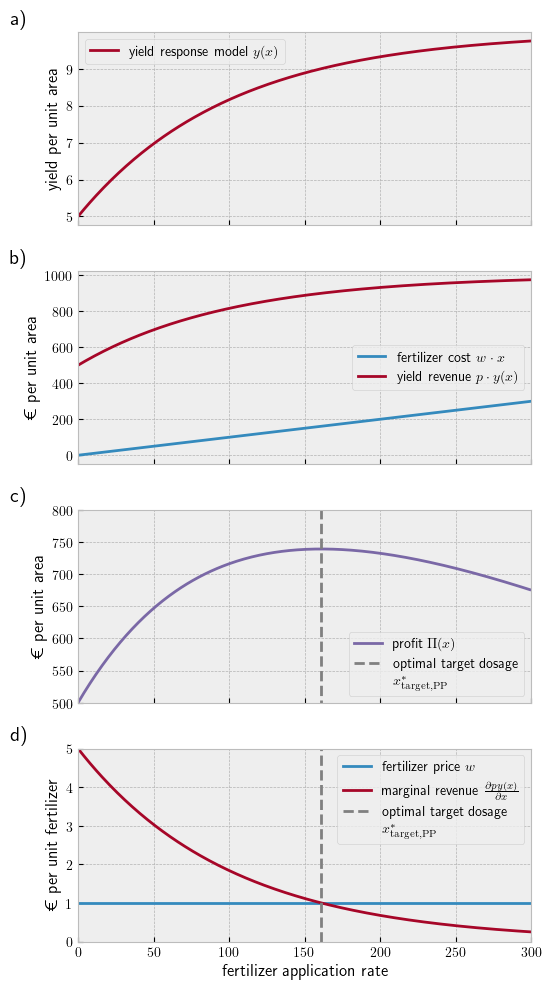

In [10]:
fig, axs = plt.subplots(4, figsize=(5.5, 10), sharex=True)
ax = axs[0]
#ax.plot(fertilizer_applied, grain_yield, c="gray", marker="o", label="observed yield (Glendining et al., 1996)")

ax.plot(fertilizer_range, grain_yield_range, c="C1", label="yield response model $y(x)$")
ax.set_ylabel('yield per unit area')
ax.legend()

ax.set_title("a)", loc="left", x=-0.15)

axs[1].plot(fertilizer_range, fertilizer_prices, label=r"fertilizer cost $w \cdot x$")
axs[1].plot(fertilizer_range, grain_prices, label=r"yield revenue $p\cdot y(x)$")
axs[1].set_ylabel('€ per unit area')
axs[1].legend()
axs[1].set_title("b)", loc="left", x=-0.15)

axs[2].plot(fertilizer_range, profit, label=r"profit $\Pi(x)$", c="C2")
axs[2].vlines(x_max_symbolic, 0, 13.5e2, color="gray", linestyle="dashed", label=r"optimal target dosage \par $x^\ast_\mathrm{target, PP}$", zorder=2)
axs[2].set_ylabel('€ per unit area')
axs[2].legend()
axs[2].set_ylim(500, 800)
axs[2].set_title("c)", loc="left", x=-0.15)

axs[3].plot(fertilizer_range, delta_fertilizer_prices, label=r"fertilizer price $w$")
axs[3].plot(fertilizer_range, delta_grain_prices, label=r"marginal revenue $\frac{\partial py(x)}{\partial x}$")
axs[3].vlines(x_max_symbolic, 0, 5.5, color="gray", linestyle="dashed", label=r"optimal target dosage \par $x^\ast_\mathrm{target, PP}$", zorder=2)
axs[3].set_ylabel('€ per unit fertilizer')
axs[3].legend()
axs[3].set_title("d)", loc="left", x=-0.15)
axs[3].set_ylim(0, 5)


axs[3].set_xlabel('fertilizer application rate')




axs[3].set_xlim(0, 300)
fig.tight_layout()

fig.savefig("synplot1.png", dpi=600)
fig.savefig("synplot1.svg")

In [11]:
def expected_profit(a, b, d, sigma, x_max):
    term1 = p * a * jnp.exp(0.5 * (b**2) * (sigma**2)) * np.exp(-b * x_max)
    term2 = p * d
    term3 = -w * x_max
    return term1 + term2 + term3

Expected value of perfect precision as a function of standard deviation.

Text(0, 0.5, 'EVPP')

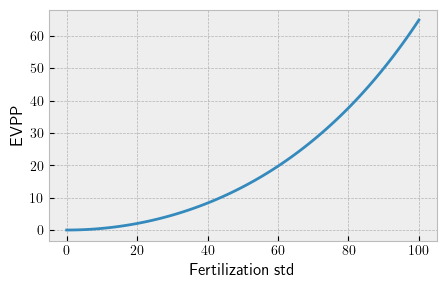

In [12]:
std_range = jnp.linspace(0, 100, 100)
std_profit = expected_profit(a, b, d, std_range, x_max_symbolic)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(std_range, expected_profit(a, b, d, 0, x_max_symbolic) -std_profit)
ax.set_xlabel("Fertilization std")
ax.set_ylabel("EVPP")

In [13]:
print(expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d)))
print(expected_profit(a, b, d, sigma, x_max_symbolic))

726.5562
725.7414


In [14]:
EVPP = expected_profit(a, b, d, 0, x_max_symbolic) - expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d))
EVPP

Array(12.5, dtype=float32)

In [15]:
key = jax.random.key(0)
random_samples = jnp.clip(jax.random.normal(key, (50000,)) * sigma + get_x_max_sigma(sigma, a, b, d), 0)

get_profit(random_samples, a, b, d).mean()

Array(726.5083, dtype=float32)

In [16]:
get_profit(random_samples, a, b, d).mean() / expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d))

Array(0.9999341, dtype=float32)

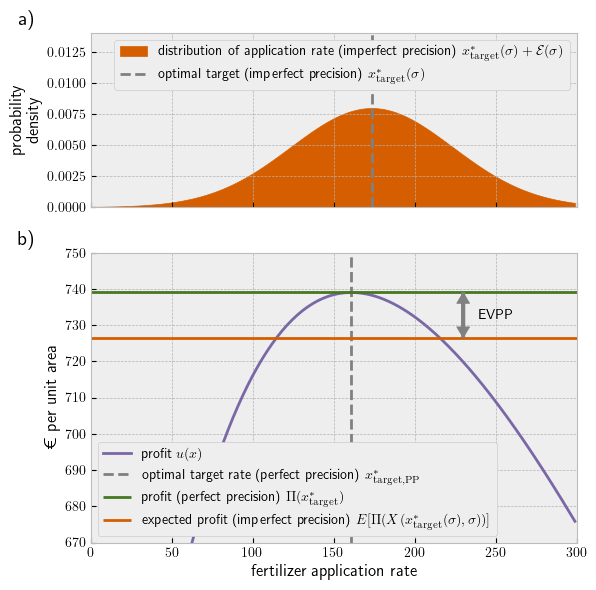

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=[3, 5])

axt = axs[0]
ax = axs[1]

mask = slice(None, None)

axt.fill_between(fertilizer_range[mask], 0, probability_density[mask], color="C4", label=r"distribution of application rate (imperfect precision)  $x^\ast_\mathrm{target}(\sigma) + \mathcal{E}(\sigma)$", alpha=1)

axt.vlines(get_x_max_sigma(sigma, a, b, d), 0, 0.02, color="gray", linestyle="dashed", label=r"optimal target (imperfect precision) $x^\ast_\mathrm{target}(\sigma)$", zorder=2)

axt.set_ylabel('probability\ndensity')
axt.set_ylim(0, 0.014)
axt.legend()
axt.set_title("a)", loc="left", x=-0.15)


ax.plot(fertilizer_range[mask], profit[mask], label="profit $u(x)$", c="C2")
ax.vlines(x_max_symbolic, 0, 1000, color="gray", linestyle="dashed", label=r"optimal target rate (perfect precision) $x^\ast_\mathrm{target, PP}$", zorder=2)
ax.hlines(expected_profit(a, b, d, 0, x_max_symbolic), 0, 300, color="C3", label=r"profit (perfect precision) $\Pi(x^\ast_\mathrm{target})$", zorder=2)
ax.hlines(expected_profit(a, b, d, 50, get_x_max_sigma(sigma, a, b, d)), 0, 300, color="C4", label=r"expected profit (imperfect precision) $E[\Pi(X(x^\ast_\mathrm{target}(\sigma), \sigma))]$", zorder=2)
ax.set_ylim(670, 750)



# First arrow (upwards)
arrow1_x = 230
arrow1_y = expected_profit(a, b, d, 50, get_x_max_sigma(sigma, a, b, d))
ax.arrow(arrow1_x, arrow1_y,
         0, EVPP, width=2, head_width=8, head_length=3, fc='gray', ec='gray',
         length_includes_head=True, zorder=8)

# Second arrow (downwards)
arrow2_x = 230
arrow2_y = expected_profit(a, b, d, 0, x_max_symbolic)
ax.arrow(arrow2_x, arrow2_y,
         0, -EVPP, width=2, head_width=8, head_length=3, fc='gray', ec='gray',
         length_includes_head=True, zorder=8)

# --- Add the textbox label using ax.annotate() ---
# Calculate the midpoint of the double arrow for text placement
text_x = arrow1_x + 10 # Offset slightly to the right of the arrows
text_y = (arrow1_y + arrow2_y) / 2

# You can format EVPP within the string.
# Using f-strings is a clean way to do this.
label_text = f"EVPP" # Formats EVPP to 2 decimal places
ax.text(text_x, text_y, label_text, ha='left', va='center',
        bbox=dict(boxstyle="round,pad=0.3", fc="lightgray", ec="black", lw=0.8, alpha=0))



ax.legend()
ax.set_ylabel('€ per unit area')
ax.set_title("b)", loc="left", x=-0.15)

#ax.set_ylim(9e4, 11.5e2)

ax.set_xlabel(r'fertilizer application rate')

axt.set_xlim(0, 300)

ax.legend().get_frame().set_alpha(1)
axt.legend().get_frame().set_alpha(1)


fig.tight_layout()

fig.savefig("synplot2.png", dpi=600)
fig.savefig("synplot2.svg")

In [18]:
def EVPP_fun(a, b, d, x_max, sigma):
    return expected_profit(a, b, d, 0, x_max) - expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d))

def EVPP_fun_analytic(a, b, d, x_max, sigma):
    return (p * (a * jnp.exp(-b * (-1/b) * jnp.log(-w / (p * a * b))) + d) \
         - w * (-1/b) * jnp.log(-w / (p * a * b)) \
         - (- p * a * jnp.exp(b**2 * sigma**2 / 2) * jnp.exp(-b * (b**2 * sigma**2 - 2 * jnp.log(-w / (p * a * b))) / (2 * b)) \
         + p * d - (w / (2 * b)) * (b**2 * sigma**2 - 2 * jnp.log(-w / (p * a * b)))))

def EVPP_fun_reduced(a, b, d, x_max, sigma):
    return (b**2 * w * sigma**2 - 4 * w) / (2 * b)

In [19]:
EVPP_fun(a, b, d, x_max_symbolic, sigma)

Array(12.5, dtype=float32)

In [20]:
EVPP_fun_reduced(a, b, d, x_max_symbolic, sigma)

-187.5

In [21]:
EVPP_fun_analytic(a, b, d, x_max_symbolic, sigma)

Array(-187.5, dtype=float32, weak_type=True)

In [22]:
print(x_max_symbolic)
print((-1/b * jnp.log(-w / (p * a * b))))

160.94379
160.94379


In [23]:
print(expected_profit(a, b, d, 0, x_max_symbolic))
print(expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d)))

739.0562
726.5562


Test symbolic solution (from Maxima)

In [24]:
print((a * jnp.exp(-b * (-1/b * jnp.log(-w / (p * a * b)))) + d) * p - w * (-1/b * jnp.log(-w / (p * a * b))).item())
print(p * a * jnp.exp((b**2 * sigma**2) / 2) * jnp.exp(-b * ((b**2 * sigma**2 - 2 * jnp.log(-w / (a * b * p))) / (2 * b))) + p * d - w * ((b**2 * sigma**2 - 2 * jnp.log(-w / (a * b * p))) / (2 * b)))

739.0562
726.5562


In [25]:
print(((b**2 * sigma**2 - 2 * jnp.log(-w / (a * b * p))) / (2 * b)))
print(get_x_max_sigma(sigma, a, b, d))

173.4438
173.4438


Symbolically simplify solution using sympy.

In [26]:
p, a, b, w, sigma, d = sympy.symbols('p a b w sigma d')
symbolic_e_u_0 = (a * sympy.exp(-b * (-1/b * sympy.log(-w / (p * a * b)))) + d) * p - w * (-1/b * sympy.log(-w / (p * a * b)))
symbolic_e_u_sigma = p * a * sympy.exp((b**2 * sigma**2) / 2) * sympy.exp(-b * ((b**2 * sigma**2 - 2 * sympy.log(-w / (a * b * p))) / (2 * b))) + p * d - w * ((b**2 * sigma**2 - 2 * sympy.log(-w / (a * b * p))) / (2 * b))
sympy.simplify(symbolic_e_u_0 - symbolic_e_u_sigma)

b*sigma**2*w/2

Create Latex math code to include in the paper.

In [27]:
sympy.latex(sympy.simplify(symbolic_e_u_0 - symbolic_e_u_sigma))

'\\frac{b \\sigma^{2} w}{2}'

In [28]:
0.5 * b * w * sigma**2

0.5*b*sigma**2*w

In [29]:
with sympy.evaluate(False):
    print(symbolic_e_u_0)

p*(d - w/(b*p)) + w*log(-w/(a*b*p))/b
